In [1]:
from tqdm import tqdm
import datetime
tqdm.pandas()
#connect local PATH
p = os.path.abspath(r'C:\Users\Ben\Desktop\Diplomatiki')
sys.path.append(str(p))
from CryptoSent.tools.crypto_coin_actual import get_btc_actual_hourly
from CryptoSent.tools import evaluation as eval
btc=get_btc_actual_hourly()
import pandas as pd
from darts import TimeSeries
from darts.metrics import mape, mase, mae, mse, ope, r2_score, rmse, rmsle


100%|██████████| 30907/30907 [00:00<00:00, 155869.64it/s]


In [2]:
# Create a TimeSeries, specifying the time and value columns
a=btc['2021-01-01':'2021-02-13'].resample('d').mean().reset_index()

series = TimeSeries.from_dataframe(a, 'datetime', 'close')
# Set aside the last 36 months as a validation series
val_len=8
train, val = series[:-val_len], series[-val_len:]

In [3]:
from darts.models import ExponentialSmoothing

model = ExponentialSmoothing()
model.fit(train)
prediction = model.predict(len(val), num_samples=1000)

C:\Users\Ben\anaconda3\envs\fbprophet\lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


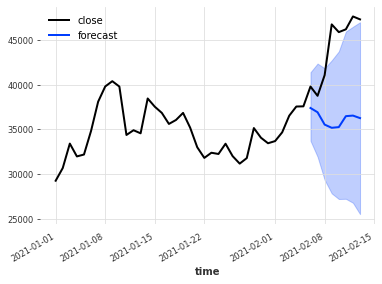

In [4]:
import matplotlib.pyplot as plt

series.plot()
prediction.plot(label='forecast', low_quantile=0.05, high_quantile=0.95)
plt.legend()

In [5]:
mape(val,prediction)

17.444795385460743

In [6]:
from darts.models import ARIMA

model = ARIMA(4,0,2)
model.fit(train)
prediction = model.predict(len(val), num_samples=1000)

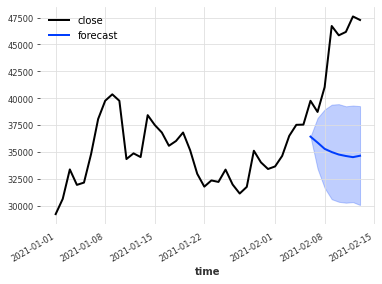

In [7]:
import matplotlib.pyplot as plt

series.plot()
prediction.plot(label='forecast', low_quantile=0.05, high_quantile=0.95)
plt.legend()

In [8]:
mape(val,prediction)

19.721494953547424

# theta


In [ ]:
from darts.models import Theta
from darts.metrics import mape, mase, mae, mse, ope, r2_score, rmse, rmsle
import numpy as np

# Create a TimeSeries, specifying the time and value columns
series = TimeSeries.from_dataframe(a, 'datetime', 'close')

# Set aside the last 36 months as a validation series
val_len=8
train, val = series[:-val_len], series[-val_len:]


# prepare Theta forecaster

# search space for best theta value: check 100 alternatives
thetas = 2 - np.linspace(-10, 10, 100)

# initialize search
best_mape = float('inf')
best_theta = 0
# search for best theta among 50 values, as measured by MAPE
for theta in thetas:
    model = Theta(theta)
    res = model.fit(train)
    pred_theta = model.predict(len(val))
    res_mape = mape(val, pred_theta)

    if res_mape < best_mape:
        best_mape = res_mape
        best_theta = theta
        print(best_mape)

m_theta = Theta(best_theta)   # best theta model among 100

[2021-12-19 16:15:50,344] INFO | darts.models.forecasting.theta | Theta model inferred seasonality of training series: 0
[2021-12-19 16:15:50,344] INFO | darts.models.forecasting.theta | Theta model inferred seasonality of training series: 0


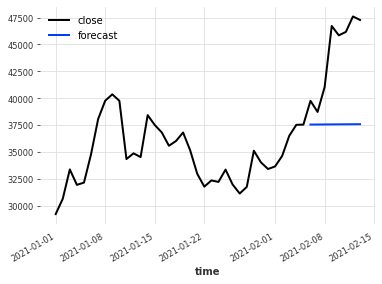

In [10]:
import matplotlib.pyplot as plt
series.plot()
m_theta.fit(train)
prediction = m_theta.predict(8)
prediction.plot(label='forecast', low_quantile=0.05, high_quantile=0.95)
plt.legend()

# rnn my approach


In [11]:
import pandas as pd
subs=pd.read_pickle(r"C:\Users\Ben\Desktop\Diplomatiki\CryptoSent\Datasets\Datasets Heisenberg\submissions_heisenberg.pickle")

In [12]:
bdf=subs[subs.topic=='Bitcoin']

C:\Users\Ben\anaconda3\envs\fbprophet\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """Entry point for launching an IPython kernel.


<AxesSubplot:xlabel='created'>

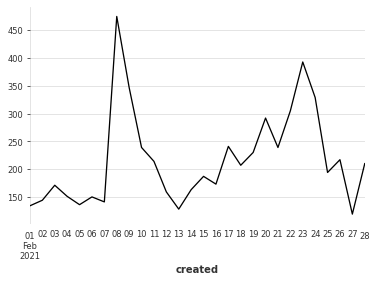

In [13]:
bdf['2021-02'].buy.resample('d').sum().plot()

In [14]:
bdf['volume']=1
bdf['buy_sell']=bdf.buy^bdf.sell

C:\Users\Ben\anaconda3\envs\fbprophet\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\Ben\anaconda3\envs\fbprophet\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import shutil
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm_notebook as tqdm

from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt

from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts.models import RNNModel, ExponentialSmoothing, BlockRNNModel
from darts.metrics import mape
from darts.utils.statistics import check_seasonality, plot_acf
from darts.datasets import AirPassengersDataset, SunspotsDataset
from darts.utils.timeseries_generation import datetime_attribute_timeseries

import warnings
warnings.filterwarnings("ignore")
import logging
logging.disable(logging.CRITICAL)

In [128]:
resample_period='h'
s1=bdf.sent_db.resample(resample_period).sum()
s2=bdf.sent_fb.resample(resample_period).sum()
s3=bdf.sent_lr.resample(resample_period).sum()
s4=bdf.sent_ntusd.resample(resample_period).sum()
s5=bdf.sent_fbt.resample(resample_period).sum()
s6=bdf.buy.resample(resample_period).sum()
s7=bdf.sell.resample(resample_period).sum()
s8=bdf.volume.resample(resample_period).sum()
s9=bdf.sent_ntusd_coms.resample(resample_period).sum()
s10=bdf.buy_sell.resample(resample_period).sum()

btcin=btc.resample(resample_period).mean().pct_change().dropna()

a=pd.concat([s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,btcin],axis=1)

In [156]:
features=['sent_db',
 'sent_fb',
 'sent_lr',
 'sent_ntusd',
 'sent_fbt',
 'buy',
 'sell',
 'volume',
 'sent_ntusd_coms',
 'buy_sell',
 'close']

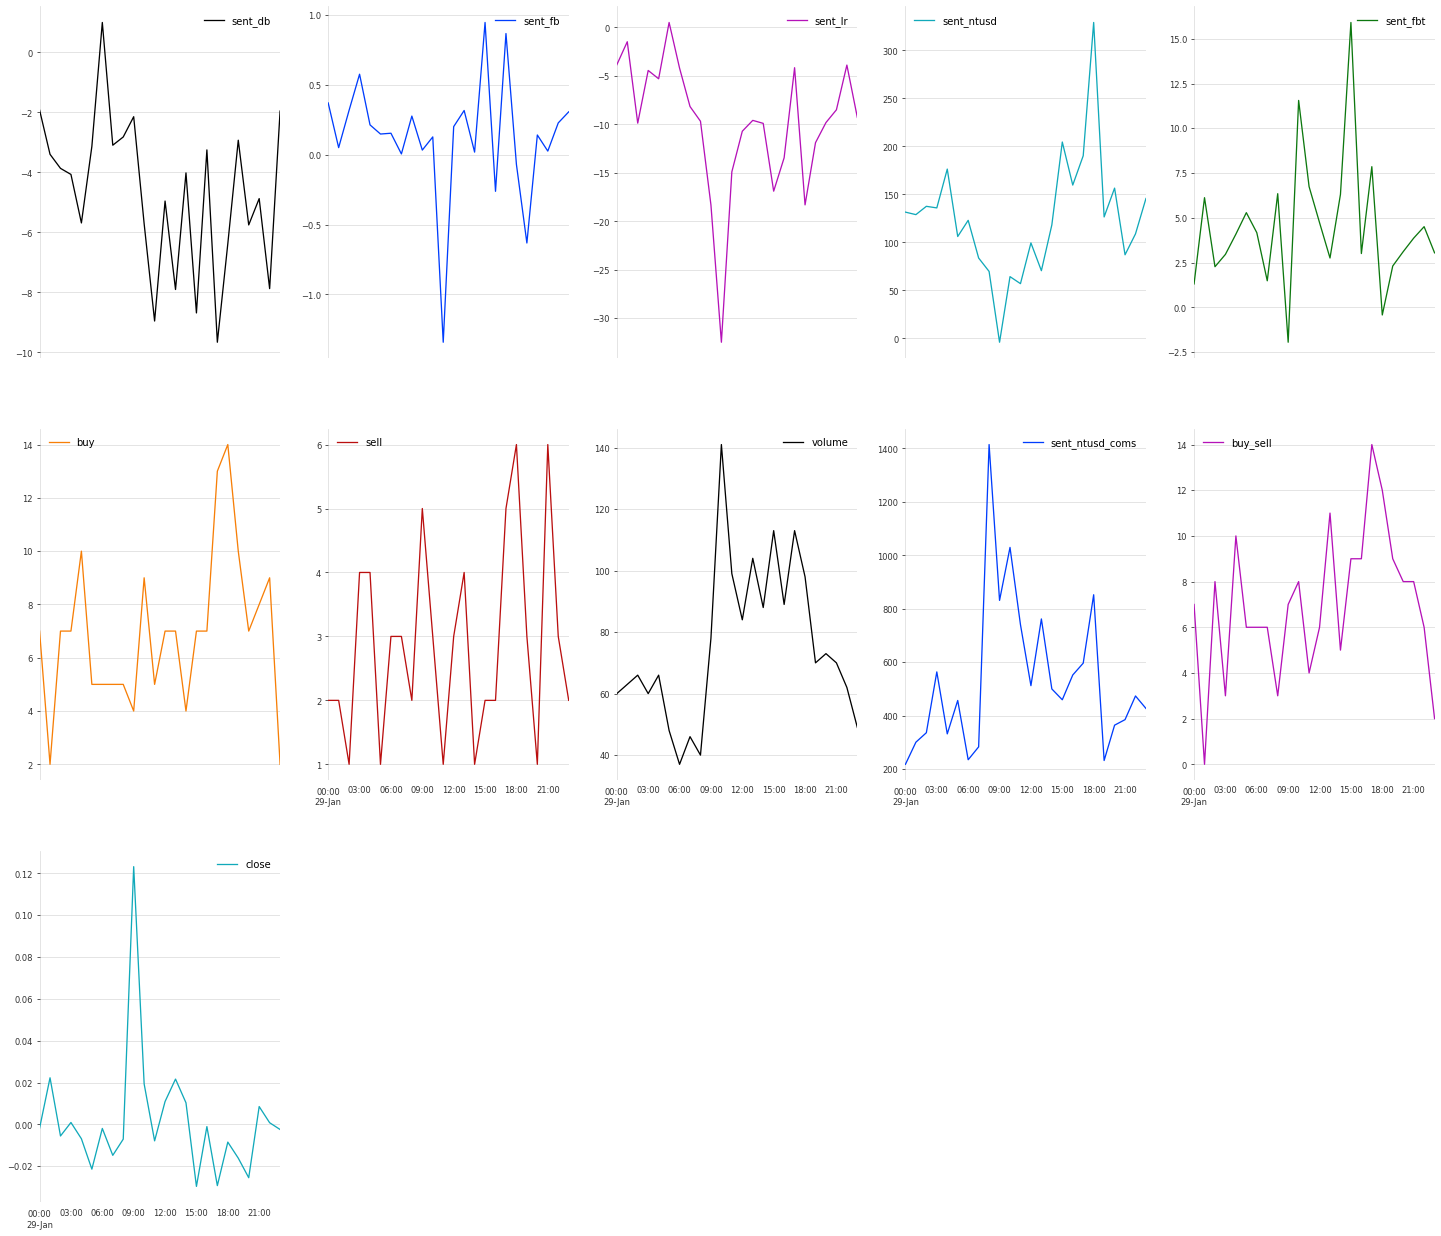

In [158]:
a[split_date:'2021-01-29'][features].dropna().plot(subplots=True, layout=(3,5),figsize=(25,22))
plt.show()

In [152]:
resample_period='h'
series_start='2021-01-20'
series_end='2021-01-30'
split_date='20210129'

s1=bdf.sent_db.resample(resample_period).sum()
s2=bdf.sent_fb.resample(resample_period).sum()
s3=bdf.sent_lr.resample(resample_period).sum()
s4=bdf.sent_ntusd.resample(resample_period).sum()
s5=bdf.sent_fbt.resample(resample_period).sum()
s6=bdf.buy.resample(resample_period).sum()
s7=bdf.sell.resample(resample_period).sum()
s8=bdf.volume.resample(resample_period).sum()
s9=bdf.sent_ntusd_coms.resample(resample_period).sum()
s10=bdf.buy_sell.resample(resample_period).sum()


btcin=btc.resample(resample_period).mean().pct_change().dropna()

a=pd.concat([s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,btcin],axis=1)
a=a[~a.sent_fbt.isna()].head(-1)
#a=a['2021-01-15':'2021-02-13']
a=a[series_start:series_end]

# Create a TimeSeries, specifying the time and value columns
series = TimeSeries.from_dataframe(a.reset_index(), 'index', 'close')
# Create training and validation sets:
train, val = series.split_after(pd.Timestamp(split_date))
future_prediction_period=len(val)

transformer = Scaler()
train_transformed = transformer.fit_transform(train)
val_transformed = transformer.transform(val)
series_transformed = transformer.transform(series)


c1=Scaler().fit_transform(TimeSeries.from_dataframe(a.reset_index(), 'index', 'volume'))


#c1=Scaler().fit_transform(TimeSeries.from_dataframe(a.reset_index(), 'index', 'sell'))
#c2=Scaler().fit_transform(TimeSeries.from_dataframe(a.reset_index(), 'index', 'sent_db'))
#c3=Scaler().fit_transform(TimeSeries.from_dataframe(a.reset_index(), 'index', 'sent_lr'))
#c4=Scaler().fit_transform(TimeSeries.from_dataframe(a.reset_index(), 'index', 'sent_fbt'))

covariates = c1#.stack(c2).stack(c3).stack(c4)
cov_train, cov_val = covariates.split_after(pd.Timestamp(split_date))

my_model = RNNModel(
    model='LSTM',
    n_rnn_layers=2, 
    hidden_dim=20,
    dropout=0.2,
    batch_size=32,
    n_epochs=50,
    optimizer_kwargs={'lr': 0.001}, 
    model_name='Air_RNN',
    log_tensorboard=True,
    random_state=42,
    training_length=40,
    input_chunk_length=12,
    force_reset=True,
    save_checkpoints=True
)
my_model.fit(train_transformed, 
             future_covariates=covariates, 
             val_series=val_transformed, 
             val_future_covariates=covariates, 
             verbose=True)




  0%|          | 0/50 [00:00<?, ?it/s]

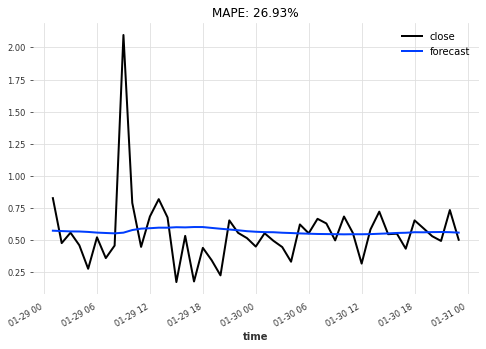

In [154]:
def eval_model(model):
    pred_series = model.predict(n=future_prediction_period, future_covariates=covariates)
    plt.figure(figsize=(8,5))
    #series_transformed.plot(label='actual')
    series_transformed[-len(pred_series):].plot()
    pred_series.plot(label='forecast')
    plt.title('MAPE: {:.2f}%'.format(mape(pred_series, val_transformed)))
    plt.legend();


eval_model(my_model)

In [ ]:
resample_period='h'
series_start='2021-01-20'
series_end='2021-01-30'
split_date='20210129'

s1=bdf.sent_db.resample(resample_period).sum()
s2=bdf.sent_fb.resample(resample_period).sum()
s3=bdf.sent_lr.resample(resample_period).sum()
s4=bdf.sent_ntusd.resample(resample_period).sum()
s5=bdf.sent_fbt.resample(resample_period).sum()
s6=bdf.buy.resample(resample_period).sum()
s7=bdf.sell.resample(resample_period).sum()
s8=bdf.volume.resample(resample_period).sum()
s9=bdf.sent_ntusd_coms.resample(resample_period).sum()
s10=bdf.buy_sell.resample(resample_period).sum()


btcin=btc.resample(resample_period).mean().pct_change().dropna()

a=pd.concat([s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,btcin],axis=1)
a=a[~a.sent_fbt.isna()].head(-1)
#a=a['2021-01-15':'2021-02-13']
a=a[series_start:series_end]

# Create a TimeSeries, specifying the time and value columns
series = TimeSeries.from_dataframe(a.reset_index(), 'index', 'close')
# Create training and validation sets:
train, val = series.split_after(pd.Timestamp(split_date))
future_prediction_period=len(val)

transformer = Scaler()
train_transformed = transformer.fit_transform(train)
val_transformed = transformer.transform(val)
series_transformed = transformer.transform(series)


c1=Scaler().fit_transform(TimeSeries.from_dataframe(a.reset_index(), 'index', 'sent_lr'))


#c1=Scaler().fit_transform(TimeSeries.from_dataframe(a.reset_index(), 'index', 'sell'))
#c2=Scaler().fit_transform(TimeSeries.from_dataframe(a.reset_index(), 'index', 'sent_db'))
#c3=Scaler().fit_transform(TimeSeries.from_dataframe(a.reset_index(), 'index', 'sent_lr'))
#c4=Scaler().fit_transform(TimeSeries.from_dataframe(a.reset_index(), 'index', 'sent_fbt'))

covariates = c1#.stack(c2).stack(c3).stack(c4)
cov_train, cov_val = covariates.split_after(pd.Timestamp(split_date))

my_model = RNNModel(
    model='LSTM',
    n_rnn_layers=2, 
    hidden_dim=20,
    dropout=0.2,
    batch_size=32,
    n_epochs=700,
    optimizer_kwargs={'lr': 0.001}, 
    model_name='Air_RNN',
    log_tensorboard=True,
    random_state=42,
    training_length=40,
    input_chunk_length=12,
    force_reset=True,
    save_checkpoints=True
)
my_model.fit(train_transformed, 
             future_covariates=covariates, 
             val_series=val_transformed, 
             val_future_covariates=covariates, 
             verbose=True)


def eval_model(model):
    pred_series = model.predict(n=future_prediction_period, future_covariates=covariates)
    plt.figure(figsize=(8,5))
    #series_transformed.plot(label='actual')
    series_transformed[-len(pred_series):].plot()
    pred_series.plot(label='forecast')
    plt.title('MAPE: {:.2f}%'.format(mape(pred_series, val_transformed)))
    plt.legend();


eval_model(my_model)

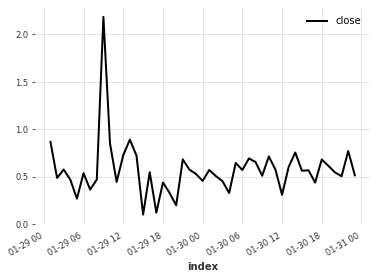

In [111]:
series_transformed[-len(val):].plot()

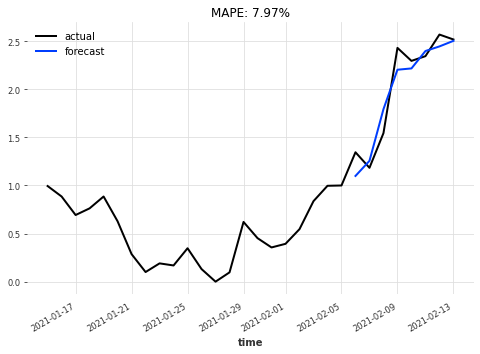

In [18]:
def eval_model(model):
    pred_series = model.predict(n=8, future_covariates=covariates)
    plt.figure(figsize=(8,5))
    series_transformed.plot(label='actual')
    pred_series.plot(label='forecast')
    plt.title('MAPE: {:.2f}%'.format(mape(pred_series, val_transformed)))
    plt.legend();
    

eval_model(my_model)

* sent_db       13 *
* sent_fb       47
* sent_lr       16 *
* sent_ntusd    41
* sent_fbt      19 *
* buy           76
* sell          9 *
* buy_sell      28

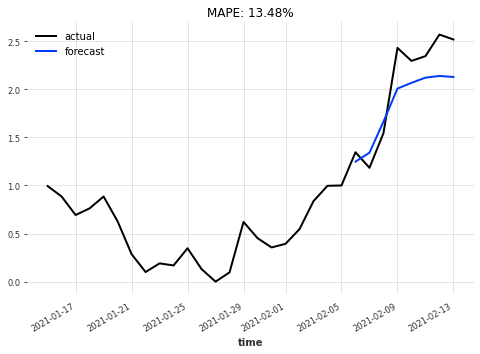

In [143]:
# 3sent
eval_model(my_model)

In [10]:
# 2 sent
def eval_model(model):
    pred_series = model.predict(n=8, future_covariates=covariates)
    plt.figure(figsize=(8,5))
    series_transformed.plot(label='actual')
    pred_series.plot(label='forecast')
    plt.title('MAPE: {:.2f}%'.format(mape(pred_series, val_transformed)))
    plt.legend();

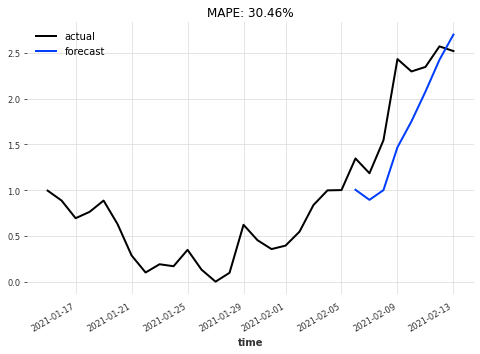

In [ ]:
    
eval_model(my_model)

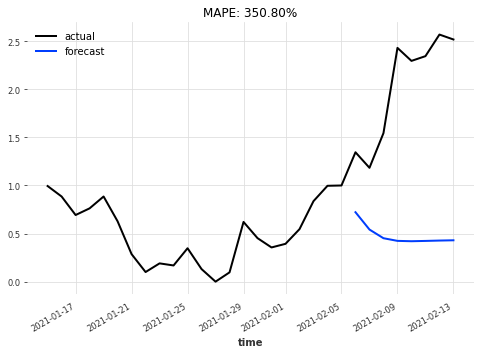

In [118]:
# just price
def eval_model(model):
    pred_series = model.predict(n=8)#, future_covariates=covariates)
    plt.figure(figsize=(8,5))
    series_transformed.plot(label='actual')
    pred_series.plot(label='forecast')
    plt.title('MAPE: {:.2f}%'.format(mape(pred_series, val_transformed)))
    plt.legend();
    
eval_model(my_model)

# top10 pred

In [9]:
bdf.head().T

created,2019-01-01 01:02:52,2019-01-01 01:05:35,2019-01-01 01:08:11,2019-01-01 01:08:21,2019-01-01 01:10:39
author,GregGriffith,bearCatBird,asazot,SMVR2,newsybitcoin
num_comments,0,11,14,12,0
score,0,0,189,6,0
title,I have a mission if you choose to accept it...,Are these accurate criticisms of Lightning Net...,May The Bulls Be With You In This 2019!,How to open a Bitcoin wallet without a bank ac...,Bitcoin fell flat in 2018 - Quartz
selftext,I heard somewhere that a majority of CSWs twee...,I'm excited about LN. I'm in progress setting ...,,"Hi, please don’t make fun of me, I’m new to Cr...",
award_name,Empty,Empty,Empty,Empty,Empty
award_description,Empty,Empty,Empty,Empty,Empty
award_count,0,0,0,0,0
award_coin_price,0,0,0,0,0
award_coin_reward,Empty,Empty,Empty,Empty,Empty


In [90]:
bdf1.author_karma.quantile>0.1

TypeError: '>' not supported between instances of 'method' and 'float'

In [ ]:
bdf1=bdf[bdf.origin!='main']
s1=bdf1.sent_db.resample('d').sum()
s2=bdf1.sent_fb.resample('d').sum()
s3=bdf1.sent_lr.resample('d').sum()
s4=bdf1.sent_ntusd.resample('d').sum()
s5=bdf1.sent_fbt.resample('d').sum()
s6=bdf1.buy.resample('d').sum()
s7=bdf1.sell.resample('d').sum()
s8=bdf1.volume.resample('d').sum()
s9=bdf1.sent_ntusd_coms.resample('d').sum()
s10=bdf1.buy_sell.resample('d').sum()


<AxesSubplot:>

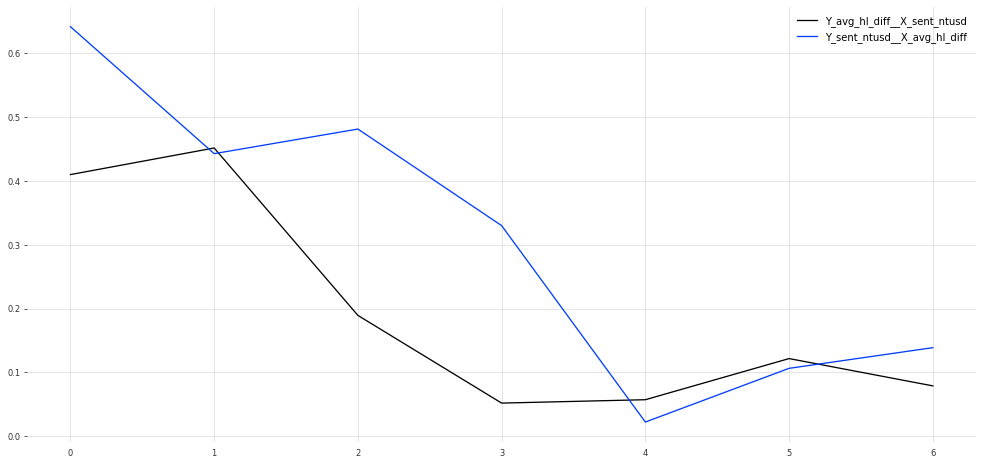

In [82]:
svar='sent_ntusd'
sin=bdf[bdf.origin!='main']['2021-01-01':'2021-02-13'][svar]
pin=btc.avg_hl
eval.get_ts_2axis(sin,pin,resample_period='d',btc_transformation='diff')
merres=eval.result_processing(sin,pin,resample_period='d')
eval.get_granger_causality(merres[[svar,'avg_hl_diff']].dropna(),maxlag=7).plot(figsize=(17,8))

  0%|          | 0/700 [00:00<?, ?it/s]

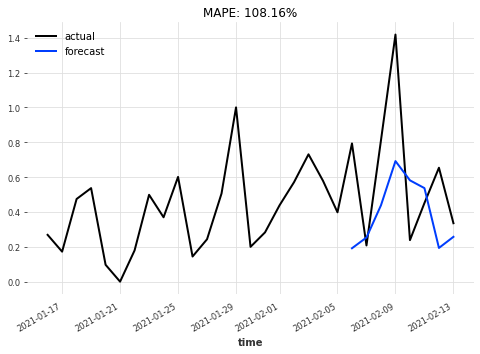

In [93]:
bdf1=bdf[bdf.origin!='main']
s1=bdf1.sent_db.resample('d').sum()
s2=bdf1.sent_fb.resample('d').sum()
s3=bdf1.sent_lr.resample('d').sum()
s4=bdf1.sent_ntusd.resample('d').sum()
s5=bdf1.sent_fbt.resample('d').sum()
s6=bdf1.buy.resample('d').sum()
s7=bdf1.sell.resample('d').sum()
s8=bdf1.volume.resample('d').sum()
s9=bdf1.sent_ntusd_coms.resample('d').sum()
s10=bdf1.buy_sell.resample('d').sum()



a=pd.concat([s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,btc.resample('d').mean()],axis=1)
a=a[~a.sent_fbt.isna()].head(-1)
a=a['2021-01-15':'2021-02-13']

# Create a TimeSeries, specifying the time and value columns
series = TimeSeries.from_dataframe(a.diff().dropna().reset_index(), 'index', 'close')
# Create training and validation sets:
train, val = series.split_after(pd.Timestamp('20210205'))

transformer = Scaler()
train_transformed = transformer.fit_transform(train)
val_transformed = transformer.transform(val)
series_transformed = transformer.transform(series)

c1=Scaler().fit_transform(TimeSeries.from_dataframe(a.reset_index(), 'index', 'sell'))
c2=Scaler().fit_transform(TimeSeries.from_dataframe(a.reset_index(), 'index', 'sent_db'))
c3=Scaler().fit_transform(TimeSeries.from_dataframe(a.reset_index(), 'index', 'sent_lr'))
c4=Scaler().fit_transform(TimeSeries.from_dataframe(a.reset_index(), 'index', 'sent_fbt'))

covariates = c1.stack(c2).stack(c3).stack(c4)
cov_train, cov_val = covariates.split_after(pd.Timestamp('20210205'))

my_model = RNNModel(
    model='LSTM',
    n_rnn_layers=2, 
    hidden_dim=20,
    dropout=0.2,
    batch_size=32,
    n_epochs=700,
    optimizer_kwargs={'lr': 0.001}, 
    model_name='Air_RNN',
    log_tensorboard=True,
    random_state=42,
    training_length=7,
    input_chunk_length=14,
    force_reset=True,
    save_checkpoints=True
)
my_model.fit(train_transformed, 
             #future_covariates=covariates, 
             val_series=val_transformed, 
             #val_future_covariates=covariates, 
             verbose=True)

# just price
def eval_model(model):
    pred_series = model.predict(n=8)#, future_covariates=covariates)
    plt.figure(figsize=(8,5))
    series_transformed.plot(label='actual')
    pred_series.plot(label='forecast')
    plt.title('MAPE: {:.2f}%'.format(mape(pred_series, val_transformed)))
    plt.legend();
    
eval_model(my_model)

# rnn example

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import shutil
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm_notebook as tqdm

from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt

from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts.models import RNNModel, ExponentialSmoothing, BlockRNNModel
from darts.metrics import mape
from darts.utils.statistics import check_seasonality, plot_acf
from darts.datasets import AirPassengersDataset, SunspotsDataset
from darts.utils.timeseries_generation import datetime_attribute_timeseries

import warnings
warnings.filterwarnings("ignore")
import logging
logging.disable(logging.CRITICAL)

In [109]:
# Read data:
series = AirPassengersDataset().load()

# Create training and validation sets:
train, val = series.split_after(pd.Timestamp('19590101'))

# Normalize the time series (note: we avoid fitting the transformer on the validation set)
transformer = Scaler()
train_transformed = transformer.fit_transform(train)
val_transformed = transformer.transform(val)
series_transformed = transformer.transform(series)

# create month and year covariate series
year_series = datetime_attribute_timeseries(pd.date_range(start=series.start_time(), freq=series.freq_str, periods=1000),
                                             attribute='year', one_hot=False)
year_series = Scaler().fit_transform(year_series)
month_series = datetime_attribute_timeseries(year_series, attribute='month', one_hot=True)
covariates = year_series.stack(month_series)
cov_train, cov_val = covariates.split_after(pd.Timestamp('19590101'))

In [116]:
my_model = RNNModel(
    model='LSTM',
    hidden_dim=20,
    dropout=0,
    batch_size=16,
    n_epochs=300,
    optimizer_kwargs={'lr': 1e-3}, 
    model_name='Air_RNN',
    log_tensorboard=True,
    random_state=42,
    training_length=20,
    input_chunk_length=14,
    force_reset=True,
    save_checkpoints=True
)

In [117]:
my_model.fit(train_transformed, 
             future_covariates=covariates, 
             val_series=val_transformed, 
             val_future_covariates=covariates, 
             verbose=True)

  0%|          | 0/300 [00:00<?, ?it/s]

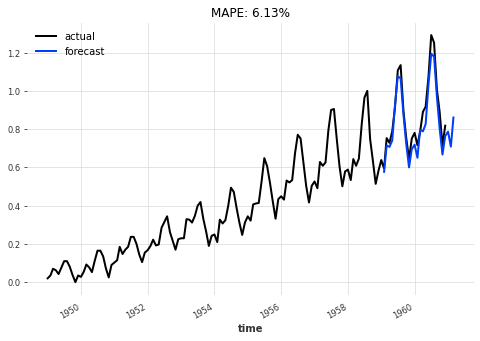

In [118]:
def eval_model(model):
    pred_series = model.predict(n=26, future_covariates=covariates)
    plt.figure(figsize=(8,5))
    series_transformed.plot(label='actual')
    pred_series.plot(label='forecast')
    plt.title('MAPE: {:.2f}%'.format(mape(pred_series, val_transformed)))
    plt.legend();
    
eval_model(my_model)

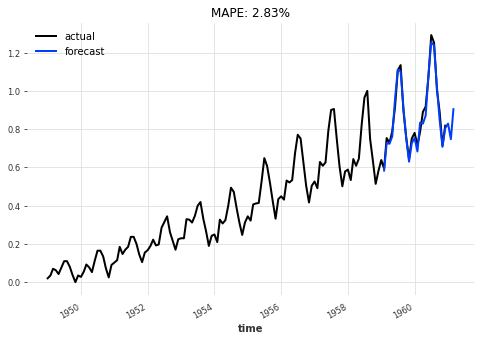

In [119]:
best_model = RNNModel.load_from_checkpoint(model_name='Air_RNN', best=True)
eval_model(best_model)

In [120]:
backtest_series = my_model.historical_forecasts(series_transformed,
                                                future_covariates=covariates,
                                                start=pd.Timestamp('19590101'),
                                                forecast_horizon=6,
                                                retrain=False,
                                                verbose=True)

  0%|          | 0/19 [00:00<?, ?it/s]

MAPE: 3.15%


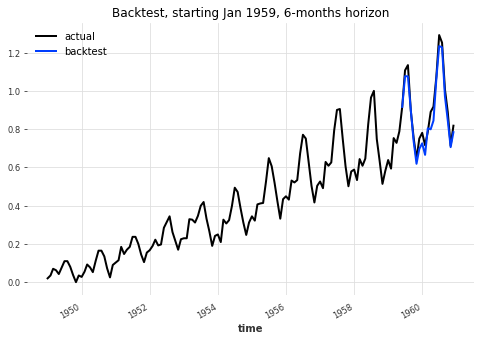

In [121]:
plt.figure(figsize=(8,5))
series_transformed.plot(label='actual')
backtest_series.plot(label='backtest')
plt.legend()
plt.title('Backtest, starting Jan 1959, 6-months horizon');
print('MAPE: {:.2f}%'.format(mape(transformer.inverse_transform(series_transformed), 
                                  transformer.inverse_transform(backtest_series))))